<a href="https://colab.research.google.com/github/Jeevesh8/knowledge_neurons/blob/main/knowledge_neurons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install transformers knowledge-neurons

In [ ]:
%%capture
from knowledge_neurons import (
    KnowledgeNeurons,
    initialize_model_and_tokenizer,
    model_type,
)

import random
import torch
import torch.nn.functional as F

# setup model, tokenizer + kn class
MODEL_NAME = "bert-base-multilingual-uncased"
model, tokenizer = initialize_model_and_tokenizer(MODEL_NAME)
kn = KnowledgeNeurons(model, tokenizer)

In [4]:
TEXT = "Sarah was visiting [MASK], the capital of france"
GROUND_TRUTH = "paris"
BATCH_SIZE = 10
STEPS = 20

ENG_TEXTS = [
    "Sarah was visiting [MASK], the capital of france",
    "The capital of france is [MASK]",
    "[MASK] is the capital of france",
    "France's capital [MASK] is a hotspot for romantic vacations",
    "The eiffel tower is situated in [MASK]",
    "[MASK] is the most populous city in france",
    "[MASK], france's capital, is one of the most popular tourist destinations in the world",
]

TEXTS = ENG_TEXTS
P = 0.5 # sharing percentage

In [ ]:
def get_attributions_scores(texts, ground_truth):
    attribution_scores_lis = []
    for prompt in texts:
        attribution_scores = kn.get_scores(prompt, ground_truth, batch_size=1)
        attribution_scores_lis.append(attribution_scores)
    return attribution_scores_lis

attribution_scores_lis = get_attributions_scores(ENG_TEXTS, GROUND_TRUTH)

Getting attribution scores for each layer...: 100%|██████████| 12/12 [00:03<00:00,  3.08it/s]


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(100,4))

In [ ]:
layer_wise_avg_scores = sum([torch.mean(attribution_scores, axis=-1) for attribution_score in attribution_scores_lis])/len(attribution_scores)

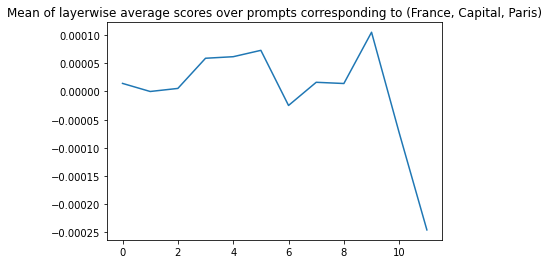

In [ ]:
plt.plot(layer_wise_avg_scores.detach().cpu().numpy())
plt.title("Mean of layerwise average scores over prompts corresponding to (France, Capital, Paris)")
plt.show()

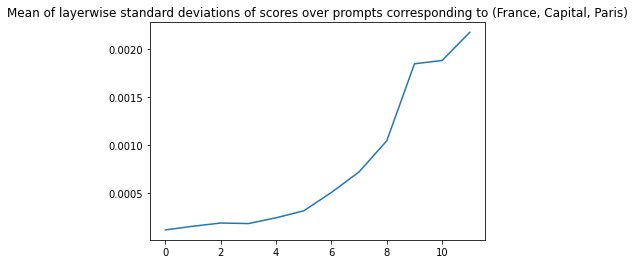

In [ ]:
layer_wise_avg_scores_std = sum([torch.std(attribution_scores, axis=-1) for attribution_score in attribution_scores_lis])/len(attribution_scores)
plt.plot(layer_wise_avg_scores_std.detach().cpu().numpy())
plt.title("Mean of layerwise standard deviations of scores over prompts corresponding to (France, Capital, Paris)")
plt.show()

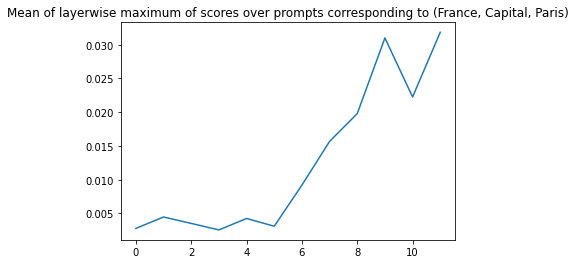

In [ ]:
layer_wise_avg_scores_std = sum([torch.max(attribution_scores, axis=-1)[0] for attribution_score in attribution_scores_lis])/len(attribution_scores)
plt.plot(layer_wise_avg_scores_std.detach().cpu().numpy())
plt.title("Mean of layerwise maximum of scores over prompts corresponding to (France, Capital, Paris)")
plt.show()

In [ ]:
refined_neurons_eng = kn.get_refined_neurons(
    ENG_TEXTS,
    GROUND_TRUTH,
    p=P,
    batch_size=BATCH_SIZE,
    steps=STEPS,
    coarse_adaptive_threshold=0.3,
)